In [88]:
using JuMP, Gurobi, Ipopt,AmplNLWriter, NLopt
using Mosek, Cbc
    k = 5              # number of waypoints
    ko = 2             # number of obstacles
    N = 3              # number of hovercrafts
    T = zeros(Int,k)   # vector of timepoints
    xw = zeros(2,k)    # vector of waypoint locations
    xo = zeros(2,ko)   # vector of obstacle locations
    bbo = zeros(2,ko)  # bounding box around obstacle


    A = [1 0;
        -1 0;
        0 1;
        0 -1;]
    bo = zeros(4,ko)
    
    T[1] = 1
    T[2] = 20
    T[3] = 40
    T[4] = 55
    T[5] = 80

    # define waypoints
    xw = [ 0   5  15  25  35
           10  8  5   3   0]
    
    xo = [ 17 13
           3  7]
    
    bbo = [ 1 1
            1 1]

    for i in 1:ko
        bo[1,i] = xo[1,i] - bbo[1,i]
        bo[2,i] = -(xo[1,i] + bbo[1,i])
        bo[3,i] = xo[2,i] - bbo[2,i]
        bo[4,i] = -(xo[2,i] + bbo[2,i])
    end;

In [ ]:
    m = Model(solver = GurobiSolver(OutputFlag=0))
    @variable(m, x[1:2,1:T[k],1:N])  # resulting position
    @variable(m, v[1:2,1:T[k],1:N])  # resulting velocity
    @variable(m, u[1:2,1:T[k],1:N])  # thruster input
    @variable(m, obstacle[1:ko,1:4,1:T[k],1:N], Bin)
    @variable(m, obstacleS[1:4,1:T[k],1:N,1:N], Bin)
    vMax = 0.5
    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1,:] .== [0;0])

    for t in 1:T[k]-1
        @constraint(m, x[:,t+1,:] .== x[:,t,:] + v[:,t,:])
        @constraint(m, v[:,t+1,:] .== v[:,t,:] + u[:,t,:])
    end
    # Avoid all obstacles
    for n in 1:N
        for o in 1:ko
            for t in 1:T[k]-1
                @constraint(m, A*x[:,t,n] .<= bo[:,o] .+ 1000*obstacle[o,:,t,n])
                @constraint(m, sum(obstacle[o,i,t,n] for i in 1:4) <= 3)
            end
        end
    end
            
    for n1 in 1:N
        for n2 in 1:N
            if n1 != n2
                for t in 3:T[k]-3
                    @constraint(m, x[1,t,n1] <= x[1,t,n2] - .5 + 1000*obstacleS[1,t,n1,n2])
                    @constraint(m, -x[1,t,n1] <= -(x[1,t,n2] + .5) + 1000*obstacleS[2,t,n1,n2])
                    @constraint(m, x[2,t,n1] <= x[2,t,n2] - .5 + 1000*obstacleS[3,t,n1,n2])
                    @constraint(m, -x[2,t,n1] <= -(x[2,t,n2] + .5) + 1000*obstacleS[4,t,n1,n2])
                    @constraint(m, sum(obstacleS[i,t,n1,n2] for i in 1:4) <= 3)
                end
            end
        end
    end
    
    # hit all the waypoints
    for t in [1 k]
        @constraint(m, x[:,T[t],:] .== xw[:,t])
    end
            

    for t in 1:T[k]
        @constraint(m, sum(v[:,t,:].^2) <= 2*vMax)
    end


    # minimize 2-norm (THIS IS LEAST-SQUARES)
    λ = 100/1
    β = 00/100
    @objective(m, Min, sum(u.^2) + λ*sum(sum((x[:,T[2:k],n]-xw[:,2:k]).^2 for n in 1:N)) + β*sum((sum((v[:,t,:] .- vMax).^2 for t in 2:T[k]))))
    solve(m)
    xopt=getvalue(x)

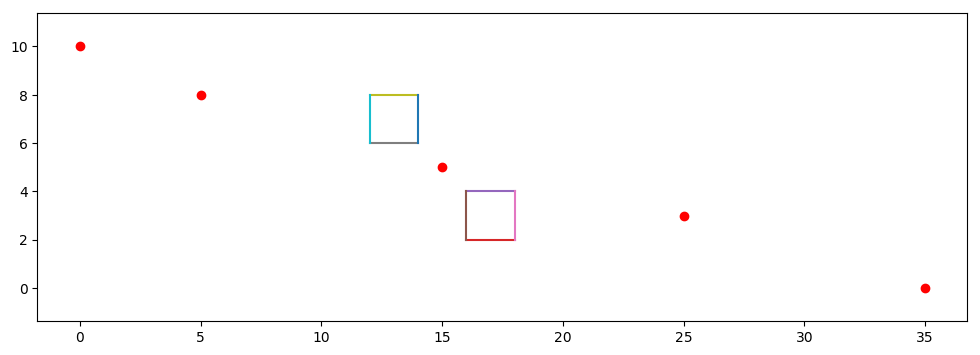

In [90]:
using PyPlot
figure(figsize=(12,4))
for n in 1:N 
    plot( xopt[1,:,n][:], xopt[2,:,n][:],".-", markersize=4 )
end

plot( xw[1,:], xw[2,:], "r.", markersize=12 )

for o in 1:ko
    # lower and upper lines
    plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
        0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] - bbo[2,o]))
    plot(linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10),
        0.*linspace(xo[1,o] - bbo[1,o],xo[1,o] + bbo[1,o],10) .+ (xo[2,o] + bbo[2,o]))

    # left and right lines
    plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] - bbo[1,o]),
        linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
    plot(0.*linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10) .+ (xo[1,o] + bbo[1,o]),
        linspace(xo[2,o] - bbo[2,o],xo[2,o] + bbo[2,o],10))
end
axis("equal");

In [61]:
getobjectivevalue(m)

29.612316153172287

In [66]:
xopt = (getvalue(x))
xopt[:,20,:]

2×3 Array{Float64,2}:
 -0.249928  -0.00023372  0.250072
  5.83328    6.33328     5.83328 

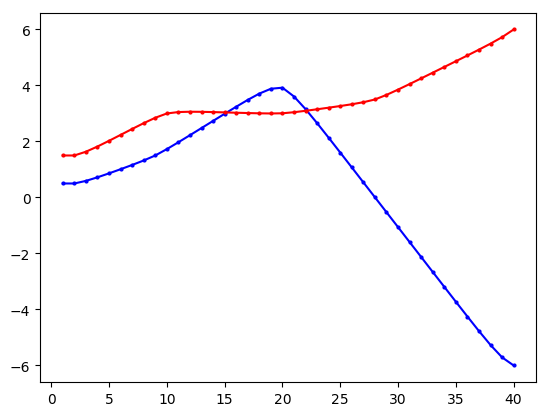

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32763cf50>

In [68]:
plot( linspace(1,40,40), xopt[1,:], "b.-", markersize=4 )
plot( linspace(1,40,40), xopt[2,:], "r.-", markersize=4 )

In [69]:
vopt = getvalue(v)

2×40 Array{Float64,2}:
 -0.0  0.0922649  0.127634  0.141478  …  -0.440266  -0.289488  0.105256
 -0.0  0.134113   0.185235  0.204489      0.231058   0.274186  0.387093

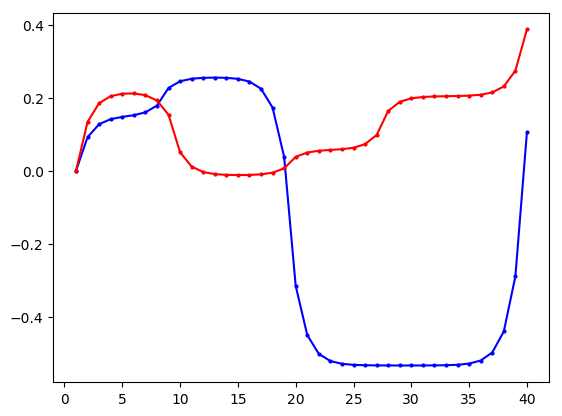

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326d1f110>

In [70]:
plot( linspace(1,40,40), vopt[1,:], "b.-", markersize=4 )
plot( linspace(1,40,40), vopt[2,:], "r.-", markersize=4 )

In [25]:
#m